In [19]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

In [20]:
# Reading data from CSV file
df = pd.read_csv("CTG.VN.csv")
df.dropna(inplace=True)

In [21]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

# Select 'Close' column
data = df['Close'].values

In [22]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Define the size of train, validation, test set
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0:train_size]
test_data = data_scaled[train_size:]

def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [23]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data, sequence_length)

# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [24]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Function to predict next `n` days using the trained LSTM model
def predict_next_days(model, last_sequence, n_days):
    forecast = []
    for _ in range(n_days):
        next_day_pred = model.predict(last_sequence)[0, 0]
        forecast.append(next_day_pred)
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[:, -1, 0] = next_day_pred
    return forecast



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [25]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error,mean_absolute_error
# Predictions for the test set
y_pred_test = model.predict(X_test)

# Inverse transform to get original values
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_test_original = scaler.inverse_transform(y_pred_test).flatten()

# Calculate metrics for test set
test_MAPE = mean_absolute_percentage_error(y_test_original, y_pred_test_original)
test_RMSE = mean_squared_error(y_test_original, y_pred_test_original, squared=False)
test_MAE = mean_absolute_error(y_test_original, y_pred_test_original)

print('Test MAPE:', test_MAPE)
print('Test RMSE:', test_RMSE)
print('Test MAE:', test_MAE)

7/7 [==============================] - 2s 30ms/step
Test MAPE: 0.023043003032097692
Test RMSE: 936.0588423678566
Test MAE: 713.297047351103


In [26]:
# Prepare final data for prediction
last_sequence_days = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)

# Predictions for the next 30, 60, 90 days
forecast_30_days = predict_next_days(model, last_sequence_days, 30)
forecast_60_days = predict_next_days(model, last_sequence_days, 60)
forecast_90_days = predict_next_days(model, last_sequence_days, 90)

# Back-transform the predicted values to get the actual value of Close
forecast_30_days = scaler.inverse_transform(np.array(forecast_30_days).reshape(-1, 1)).flatten()
forecast_60_days = scaler.inverse_transform(np.array(forecast_60_days).reshape(-1, 1)).flatten()
forecast_90_days = scaler.inverse_transform(np.array(forecast_90_days).reshape(-1, 1)).flatten()

1/1 [==============================] - 0s 47ms/step


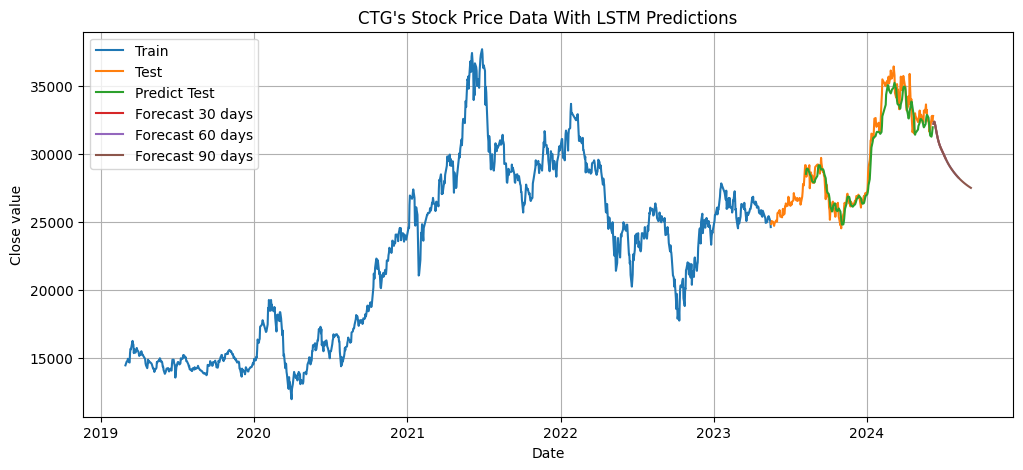

In [27]:
# Plotting the data
plt.figure(figsize=(12, 5))

# Training set
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), label='Train')

# Test set
plt.plot(df.index[train_size:], scaler.inverse_transform(test_data), label='Test')

# Predictions on test set
test_pred_index = df.index[train_size + sequence_length - 1:train_size + len(y_test) + sequence_length - 1]
plt.plot(test_pred_index, scaler.inverse_transform(y_pred_test), label='Predict Test')

# Forecast for the next 30, 60, 90 days
last_date = df.index[-1]
next_dates_30 = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30)
next_dates_60 = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60)
next_dates_90 = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)
plt.plot(next_dates_30, forecast_30_days, label='Forecast 30 days')
plt.plot(next_dates_60, forecast_60_days, label='Forecast 60 days')
plt.plot(next_dates_90, forecast_90_days, label='Forecast 90 days')

plt.legend()
plt.grid(True)
plt.title("CTG's Stock Price Data With LSTM Predictions")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.show()